In [1]:
import torch 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt 
from torch.func import vmap, grad
from tqdm import tqdm
from torch.distributions import MultivariateNormal
import torchkbnufft as tkbn

plt.style.use("dark_background")
sys.path.append("..\\")
sys.path.append("./ipa/")
plt.style.use("dark_background")
device = "cuda" if torch.cuda.is_available() else "cpu"
weights_prior = torch.load("../weights_1000ep.pt")
from model import ScoreNetwork0
score_prior = ScoreNetwork0().to(device)
score_prior.load_state_dict(weights_prior)

<All keys matched successfully>

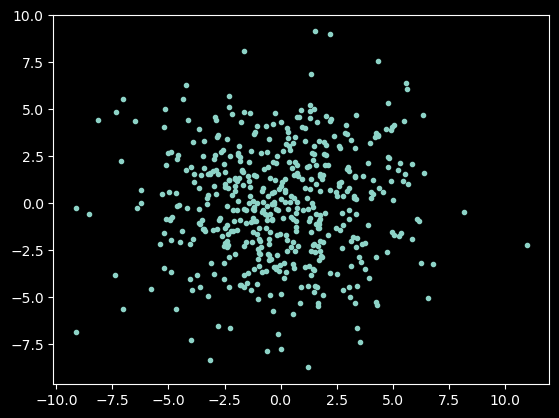

In [2]:
N = 500
uv =  3 * torch.randn([N, 2]).to(device)
plt.plot(uv[:, 0].cpu(), uv[:, 1].cpu(), ".")

In [3]:
pixels = 28
def nufft_forward(im, uv_points, smaps=None):
    nufft = tkbn.KbNufft(im_size=[pixels, pixels], device=device, numpoints=5, grid_size=[int(1.5*pixels), int(1.5*pixels)], table_oversamp=1)
    return nufft.forward(im.cfloat(), uv_points.t(), smaps=smaps, norm = None)/pixels  # By definition

def dirty_image(vis, uv_points, grid_size, smaps=None):
    dcomp = tkbn.calc_density_compensation_function(uv_points.T, grid_size)
    inv_fft = tkbn.KbNufftAdjoint(im_size=grid_size, grid_size=[int(1.5*n) for n in grid_size], device=device, numpoints=5, table_oversamp=1)
    return inv_fft.forward(vis * dcomp, uv_points.T, smaps=smaps)

In [4]:
dataset = torch.load("../../MNIST_torch/test_images.pt")
k = np.random.randint(len(dataset))
img_size = 28
x = dataset[k].reshape(img_size, img_size).to(device)

visibility = nufft_forward(x[None, None, ...], uv)
dirty_x = dirty_image(visibility, uv, [28, 28])
visibility = visibility.flatten()
visibility = torch.cat([visibility.real, visibility.imag])

In [5]:
a = grad(torch.sum(nufft_forward(x[None, None, ...], uv).real))

In [7]:
y_dim = len(visibility)
sigma_likelihood = 0.1
dist_likelihood = MultivariateNormal(loc = torch.zeros(y_dim, device = x.device), covariance_matrix=sigma_likelihood**2 * torch.eye(y_dim, device = x.device))
eta = dist_likelihood.sample([])
y = visibility + eta

TypeError: Invalid shape (784,) for image data

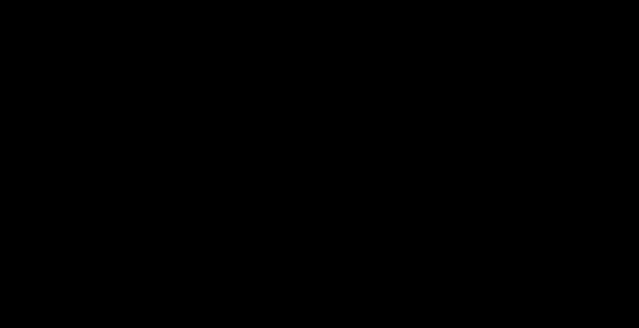

In [8]:
# Just viewing 
y_rec = (y[:int(y_dim/2)] + 1j * y[int(y_dim/2):]).reshape(1, 1, 500)
dirty_x_rec = dirty_image(y_rec, uv, [28, 28])

n_cols = 2
fig, axs = plt.subplots(1, n_cols, figsize = (n_cols * 4, 4))

for i in range(len(axs)): 
    axs[i].axis("off")
axs[0].imshow(x.cpu(), cmap = "gray")
axs[1].imshow(dirty_x_rec[0, 0].real.cpu(), cmap = "gray")


In [65]:
visibility.shape

torch.Size([1000])

In [11]:
dataset = torch.load("../../MNIST_torch/test_images.pt")
k = np.random.randint(len(dataset))
img_size = 28
x = dataset[k].reshape(img_size, img_size).to(device)

def nufft_forward(im, uv_points, smaps=None):
    nufft = tkbn.KbNufft(im_size=[pixels, pixels], device=device, numpoints=5, grid_size=[int(1.5*pixels), int(1.5*pixels)], table_oversamp=1)
    return nufft.forward(im.cfloat(), uv_points.t(), smaps=smaps, norm = None)/pixels  # By definition

def dirty_image(vis, uv_points, grid_size, smaps=None):
    dcomp = tkbn.calc_density_compensation_function(uv_points.T, grid_size)
    inv_fft = tkbn.KbNufftAdjoint(im_size=grid_size, grid_size=[int(1.5*n) for n in grid_size], device=device, numpoints=5, table_oversamp=1)
    return inv_fft.forward(vis * dcomp, uv_points.T, smaps=smaps)

visibility = nufft_forward(x[None, None, ...], uv)
dirty_x = dirty_image(visibility, uv, [28, 28])
visibility = visibility.flatten()
visibility = torch.cat([visibility.real, visibility.imag])

y_dim = len(visibility)
sigma_likelihood = 0.1
dist_likelihood = MultivariateNormal(loc = torch.zeros(y_dim, device = x.device), covariance_matrix=sigma_likelihood**2 * torch.eye(y_dim, device = x.device))
eta = dist_likelihood.sample([])
y = visibility + eta

def beta(t): 
    return 0.1 + (20-0.1) * t
def int_beta(t): 
    return 0.1 * t + (20 - 0.1) * t **2 / 2
 
def sigma(t): 
    return torch.sqrt(1-torch.exp(-int_beta(t)))

def logprob_likelihood(x, cov_mat): 
    dist = torch.distributions.MultivariateNormal(loc = torch.zeros(y_dim, device = x.device), covariance_matrix = cov_mat, validate_args=False)
    return dist.log_prob(x)

def log_likelihood(y, x, t): 
    pdf = -torch.sum((y-f(x))**2)/(2*(sigma_likelihood ** 2 + sigma(t) **2))
    return pdf

def f(x): 
    x = x.reshape(-1, img_size, img_size)
    vis = nufft_forward(x[:, None, ...], uv)
    vis = vis.squeeze(1).flatten(-1)
    vis = torch.cat([vis.real, vis.imag], dim = -1)

    return vis

def score_likelihood(x, t): 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t)))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    return score_prior(x, t) + score_likelihood(x, t)

x = torch.randn([10, img_size ** 2]).to(device) 
t = torch.ones(size = [10, 1]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
#print(score_posterior(x, t))

RuntimeError: Cannot access data pointer of Tensor that doesn't have storage

In [12]:
y.shape

torch.Size([1000])

In [16]:
vmap(grad(lambda x: torch.sum(f(x))))(x)

RuntimeError: Cannot access data pointer of Tensor that doesn't have storage

In [71]:
print(f(x).shape)

torch.Size([10, 1, 500])
torch.Size([10, 1000])
